<a href="https://colab.research.google.com/github/LamaAldakhil/ScCvT/blob/main/TestScCvt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers torch pandas numpy scikit-learn pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 110.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.4 MB/s eta 0:00:00


In [ ]:
pip install --upgrade huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import json
import requests
import pandas as pd
from PIL import Image
import time
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

API_URL = "https://api-inference.huggingface.co/models/LamaAldakhil/ScCvT_K-fold"
headers = {"Authorization": "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"}

ground_truth_csv = "/content/drive/MyDrive/HAM/test/ISIC2018_Task3_Test_GroundTruth.csv"
df = pd.read_csv(ground_truth_csv)

image_folder = "/content/drive/MyDrive/HAM/test"


def query(image_path):
    with open(image_path, "rb") as f:
        data = f.read()
    response = requests.request("POST", API_URL, headers=headers, data=data)

    if response.status_code != 200:
        print(f"Error: API request failed with status code {response.status_code}")
        print(response.text)
        return None

    try:
        return json.loads(response.content.decode("utf-8"))
    except json.JSONDecodeError as e:
        print(f"Error: Unable to parse JSON response: {e}")
        print(response.content.decode("utf-8"))
        return None

def process_api_response(response):
    if 'error' in response:
        print(f"Error: {response['error']}")
        return None, None

    if isinstance(response, list):
        max_score = 0
        predicted_label = None

        for item in response:
            if item['score'] > max_score:
                max_score = item['score']
                predicted_label = item['label']

        return predicted_label, max_score
    else:
        print(f"Unexpected response format: {response}")
        return None, None

wait_for_model = True  # Boolean flag to enable/disable waiting between API requests
initial_wait_seconds = 60  # Initial number of seconds to wait before retrying the request
max_retries = 5  # Maximum number of times to retry the request

def query_with_wait(image_path, initial_wait_seconds, max_retries):
    wait_seconds = initial_wait_seconds
    retries = 0
    response = None

    while retries < max_retries:
        response = query(image_path)
        if response is not None:
            break

        time.sleep(wait_seconds)
        wait_seconds *= 2
        retries += 1

    return response

correct_predictions = 0
total_predictions = 0

y_true = []
y_pred = []

cooldown_seconds = 60
request_count = 0

for index, row in df.iterrows():
    image_filename = row['image'] + ".jpg"
    image_path = os.path.join(image_folder, image_filename)

    if os.path.exists(image_path):
        if wait_for_model:
            predictions = query_with_wait(image_path, initial_wait_seconds, max_retries)
        else:
            predictions = query(image_path)

        request_count += 1
        if request_count % 50 == 0:
            print(f"Number of predictions made so far: {request_count}")
            print(f"Waiting for {cooldown_seconds} seconds cooldown...")
            time.sleep(cooldown_seconds)

        if predictions is None:
            print(f"Warning: Predicted label is None for {image_filename}")
            continue

        predicted_label, max_score = process_api_response(predictions)

        if predicted_label is None:
            print(f"Warning: Predicted label is None for {image_filename}")
            continue

        true_label = row[row == 1].index[0]

        y_true.append(true_label)
        y_pred.append(predicted_label)

        if predicted_label == true_label:
            correct_predictions += 1

        total_predictions += 1
    else:
        print(f"Image not found: {image_path}")

# Calculate accuracy, F1 score, and confusion matrix
accuracy = correct_predictions / total_predictions
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Number of predictions made so far: 50
Waiting for 60 seconds cooldown...
Number of predictions made so far: 100
Waiting for 60 seconds cooldown...
Error: API request failed with status code 503
{"error":"Model LamaAldakhil/ScCvT_K-fold is currently loading","estimated_time":20.0}
Error: API request failed with status code 503
{"error":"Model LamaAldakhil/ScCvT_K-fold is currently loading","estimated_time":20.0}
Number of predictions made so far: 150
Waiting for 60 seconds cooldown...
Number of predictions made so far: 200
Waiting for 60 seconds cooldown...
Error: API request failed with status code 503
{"error":"Model LamaAldakhil/ScCvT_K-fold is currently loading","estimated_time":20.0}
Error: API request failed with status code 503
{"error":"Model LamaAldakhil/ScCvT_K-fold is currently loading","estimated_time":20.0}
Number of predictions made so far: 250
Waiting for 60 seconds cooldown...
Number of predictions made so far: 300
Waiting for 60 seconds cooldown...
Number of predictions

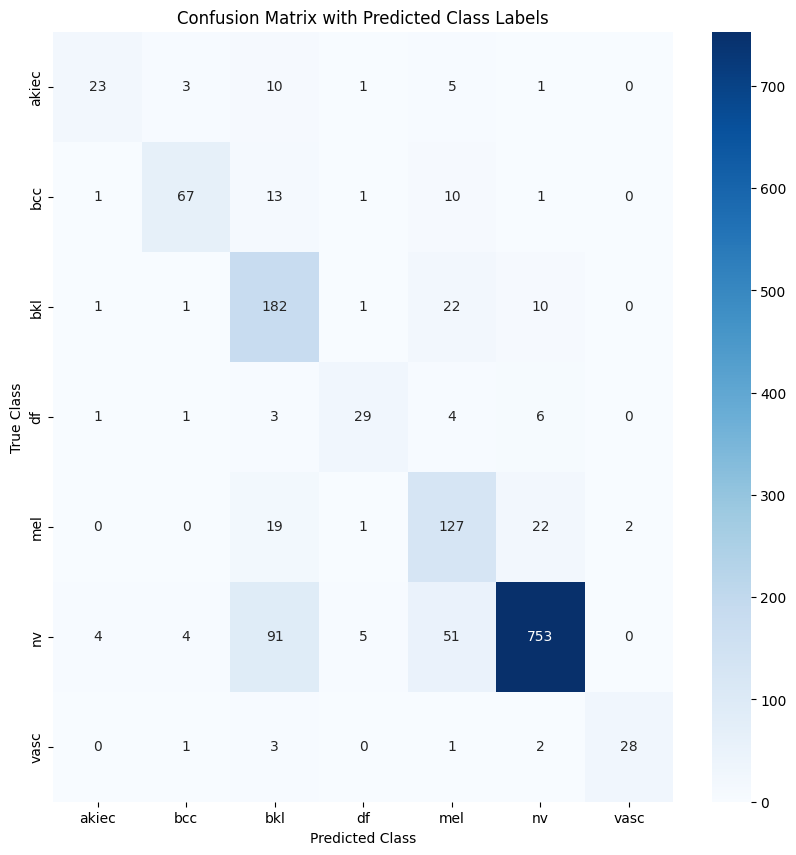

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Get the unique class labels
class_labels = sorted(list(set(y_true)))

# Create a DataFrame with the confusion matrix values and class labels
cm_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", cbar=True)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix with Predicted Class Labels")
plt.show()

In [ ]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
